In [4]:
import pandas as pd
import os
import json
from scipy.stats import pearsonr, spearmanr
from tabulate import tabulate

## PROBE_HUMAN_AGREEMENT

In [5]:
MODELS = ["Qwen-Qwen2.5-Math-1.5B-Instruct", "Qwen-Qwen2.5-Math-7B-Instruct"]
PROBING_DATASET = "DigitalLearningGmbH_MATH-lighteval"
LABELLED_DATASET = "DigitalLearningGmbH_MATH-lighteval"

In [6]:
if LABELLED_DATASET == "DigitalLearningGmbH_MATH-lighteval":
    COLS_OF_INTEREST = ["problem_id", "problem", "score", "calibrated_raw_score", "calibrated_score", 'level']
else:
    COLS_OF_INTEREST = ["problem_id", "problem", "score", "calibrated_raw_score", "calibrated_score"]

merged_df = None

for MODEL_NAME in MODELS:
    DATA_PATH = f"../probe_results/DATA/Labelled_SR/DigitalLearningGmbH_MATH-lighteval_probe/{LABELLED_DATASET}/{MODEL_NAME}_maxlen_3000_k_5_temp_0.6/scored.parquet"
    temp_df = pd.read_parquet(DATA_PATH)[COLS_OF_INTEREST].copy()
    size = MODEL_NAME.split('-')[-2]  # e.g., '1.5B' or '7B'
    temp_df = temp_df.rename(columns={
        "score": f"score_{size}",
        "calibrated_raw_score": f"calibrated_raw_score_{size}",
        "calibrated_score": f"calibrated_score_{size}",
    })
    if merged_df is None:
        merged_df = temp_df
    else:
        merged_df = pd.merge(
            merged_df,
            temp_df.drop(columns=["problem", "level"]),  # avoid duplicate columns
            on="problem_id",
            suffixes=('', f'_{size}')
        )
if LABELLED_DATASET == "DigitalLearningGmbH_MATH-lighteval":
    merged_df["level"] = merged_df["level"].apply(lambda x: int(x.split(" ")[-1]))

In [7]:
merged_df

,problem_id,problem,score_1.5B,calibrated_raw_score_1.5B,calibrated_score_1.5B,level,score_7B,calibrated_raw_score_7B,calibrated_score_7B
0,SG93IG1hbnkgdmVydGljYWwgYXN5bXB0b3RlcyBkb2VzIH...,How many vertical asymptotes does the graph of...,0.731692,3.505925,0.970856,3,0.724103,3.255633,0.962875
1,V2hhdCBpcyB0aGUgcG9zaXRpdmUgZGlmZmVyZW5jZSBiZX...,What is the positive difference between $120\%...,0.745599,4.035837,0.982636,1,0.741552,3.929518,0.980726
2,RmluZCAkeCQgc3VjaCB0aGF0ICRcbGNlaWwgeCBccmNlaW...,Find $x$ such that $\lceil x \rceil + x = \dfr...,0.700794,2.386949,0.915827,4,0.712682,2.828835,0.944214
3,RXZhbHVhdGUgJGleNStpXnstMjV9K2leezQ1fSQuIExldC...,Evaluate $i^5+i^{-25}+i^{45}$. Let's think ste...,0.745337,4.025678,0.982462,5,0.718458,3.043358,0.954495
4,SWYgJDJeOD00XngkLCB3aGF0IGlzIHRoZSB2YWx1ZSBvZi...,"If $2^8=4^x$, what is the value of $x$? Let's ...",0.735206,3.638111,0.974372,1,0.743827,4.019496,0.982355
...,...,...,...,...,...,...,...,...,...
4995,SWYgJFxzaW4geCArIFxjb3MgeCA9IFxmcmFjezF9ezV9JC...,If $\sin x + \cos x = \frac{1}{5}$ and $0 < x ...,0.687326,1.920415,0.872185,5,0.706652,2.607587,0.931348
4996,VGhlIG1hdHJpeCBmb3IgcHJvamVjdGluZyBvbnRvIGEgY2...,The matrix for projecting onto a certain plane...,0.661708,1.061869,0.743048,5,0.679495,1.642095,0.837820
4997,TGV0ICRcbWF0aGJme2F9LCQgJFxtYXRoYmZ7Yn0sJCBhbm...,"Let $\mathbf{a},$ $\mathbf{b},$ and $\mathbf{c...",0.717282,2.974868,0.951426,4,0.729886,3.475904,0.969994
4998,RmluZCB0aGUgc21hbGxlc3QgcG9zaXRpdmUgaW50ZWdlci...,Find the smallest positive integer solution to...,0.662508,1.088182,0.748039,5,0.650445,0.655941,0.658348


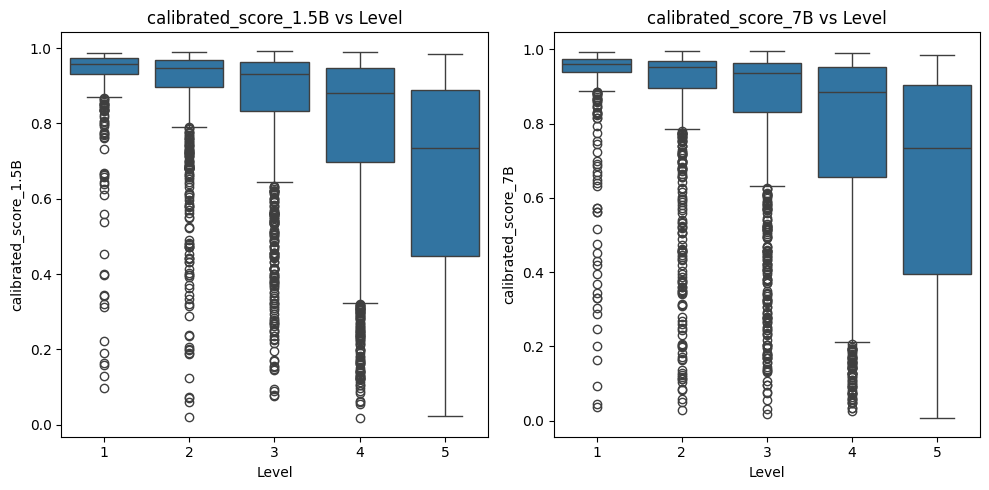

In [8]:
import seaborn as sns

import matplotlib.pyplot as plt

# Convert 'level' to numeric for correlation analysis
merged_df['level_num'] = pd.to_numeric(merged_df['level'], errors='coerce')

plt.figure(figsize=(10, 5))

# Plot for calibrated_score_1.5B vs level
plt.subplot(1, 2, 1)
sns.boxplot(x='level_num', y='calibrated_score_1.5B', data=merged_df)
plt.title('calibrated_score_1.5B vs Level')
plt.xlabel('Level')
plt.ylabel('calibrated_score_1.5B')

# Plot for calibrated_score_7B vs level
plt.subplot(1, 2, 2)
sns.boxplot(x='level_num', y='calibrated_score_7B', data=merged_df)
plt.title('calibrated_score_7B vs Level')
plt.xlabel('Level')
plt.ylabel('calibrated_score_7B')

plt.tight_layout()
plt.show()

In [9]:
print(
    f"Correlation between human difficulty annotations and SR predicted difficulty\n"
    f"Dataset: {LABELLED_DATASET} | Probes trained on: {PROBING_DATASET}\n"
)
results = [
    ["Model", "Correlation Type", "Correlation", "p-value"],
    ["1.5B", "Pearson", f"{pearsonr(merged_df['calibrated_score_1.5B'], merged_df['level_num'])[0]:.4f}", f"{pearsonr(merged_df['calibrated_score_1.5B'], merged_df['level_num'])[1]:.4g}"],
    ["7B", "Pearson", f"{pearsonr(merged_df['calibrated_score_7B'], merged_df['level_num'])[0]:.4f}", f"{pearsonr(merged_df['calibrated_score_7B'], merged_df['level_num'])[1]:.4g}"],
    ["1.5B", "Spearman", f"{spearmanr(merged_df['calibrated_score_1.5B'], merged_df['level_num'])[0]:.4f}", f"{spearmanr(merged_df['calibrated_score_1.5B'], merged_df['level_num'])[1]:.4g}"],
    ["7B", "Spearman", f"{spearmanr(merged_df['calibrated_score_7B'], merged_df['level_num'])[0]:.4f}", f"{spearmanr(merged_df['calibrated_score_7B'], merged_df['level_num'])[1]:.4g}"],
]
print(tabulate(results[1:], headers=results[0], tablefmt="github"))
print()
print("Note: Human levels are annotated from 1 (easy) to 5 (hard).\n" \
"SR scores: higher means easier (1 = easy, 0 = hard).")

Correlation between human difficulty annotations and SR predicted difficulty
Dataset: DigitalLearningGmbH_MATH-lighteval | Probes trained on: DigitalLearningGmbH_MATH-lighteval

| Model   | Correlation Type   |   Correlation |    p-value |
|---------|--------------------|---------------|------------|
| 1.5B    | Pearson            |       -0.3939 | 2.834e-185 |
| 7B      | Pearson            |       -0.3725 | 2.556e-164 |
| 1.5B    | Spearman           |       -0.4605 | 4.594e-261 |
| 7B      | Spearman           |       -0.4431 | 1.579e-239 |

Note: Human levels are annotated from 1 (easy) to 5 (hard).
SR scores: higher means easier (1 = easy, 0 = hard).
